# Assignment 1
- s113604 Mark Ian Svenningsen
- s113627 Casper Clemmensen
- s146893 Kasper Hoa Quoc Duong

## Assignment 1A: Anscombe's quartet

### Using the `numpy` function `mean`, calculate the mean of both $x$-values and $y$-values for each dataset.

We start out by downloading the data `data` to memory. Afterwards we transform the data `data_t` to a more appropriate format we can work with in Python. 

In [65]:
import urllib2
import numpy as np

# Downloads data given a url using urllib2
def getTsv(url):
    req = urllib2.Request(url)
    response = urllib2.urlopen(req)
    return response.read()

# Transforms the input data from a tabular seperated 
# file and casts the values to floats.
def transform(data):
    return np.array([[float(x) for x in line.split('\t')] for line in data.split('\n')])
    

data = [
    getTsv('https://dl.dropboxusercontent.com/u/153071/teaching/02806_2016/data1.tsv'),
    getTsv('https://dl.dropboxusercontent.com/u/153071/teaching/02806_2016/data2.tsv'),
    getTsv('https://dl.dropboxusercontent.com/u/153071/teaching/02806_2016/data3.tsv'),
    getTsv('https://dl.dropboxusercontent.com/u/153071/teaching/02806_2016/data4.tsv')
    ]

data_t = [transform(d) for d in data]

`data_t` now represents 4 lists containing a list of two elements (x,y) for each row of the tsv files.

Next, we calculate all the mean values. We use numpy as it has an easy way to calculate the mean of values in a numpy array. More specifically we can call a function on each of the four lists getting the mean across indexes. 

See the documentation [here](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.mean.html) for more details.

In [66]:
import numpy as np

# Calculates the mean values of a lists sublists/tuples 
# on the axis 0, i.e. up/down (axis=1, right,left)

means = [dt.mean(axis=0) for dt in data_t]

### Use python string formatting to print precisely two decimal places of these results to the output cell. Check out this stackoverflow page for help with the string formatting.

In [67]:
for m in means:
    print "Mean: {:10.2f},{:10.2f}".format(*m)

Mean:       9.00,      7.50
Mean:       9.00,      7.50
Mean:       9.00,      7.50
Mean:       9.00,      7.50


### Now calculate the variance for all of the various sets of x- and y-values (to three decimal places).

As we did with the means we can calculate the variance in x- and y-values the same way for each dataset.

In [68]:
variance = [dt.var(axis=0) for dt in data_t]

for v in variance:
    print "Variance: {:10.3f},{:10.3f}".format(*v)

Variance:     10.000,     3.752
Variance:     10.000,     3.752
Variance:     10.000,     3.748
Variance:     10.000,     3.748


### Use `numpy` to calculate the [Pearson correlation](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient) between $x$- and $y$-values for all four data sets (also to three decimal places).

As before we use a list comprehension on the transformed data `data_t` calling a simple function that calculates the pearson correlation on each of the 4 datasets.

In [69]:
# Calculates the pearson correlation for 
# each dataset
def calc_pearson(data):
    data_xs = data[:,0] # all xs across sublists/tuples
    data_ys = data[:,1] # all xs across sublists/tuples
    return np.corrcoef(data_xs, data_ys)[0][1]
    
pears = [calc_pearson(x) for x in data_t]

for pear in pears:
    print "Pearson: {:10.3f}".format(pear)

Pearson:      0.816
Pearson:      0.816
Pearson:      0.816
Pearson:      0.817


### The next step is use _linear regression_ to fit a straight line $f(x) = a x + b$ through each dataset and report $a$ and $b$ (to two decimal places). An easy way to fit a straight line in Python is using `scipy`'s `linregress`.

Before we start plotting, lets first generate the straigt lines needed for each dataset.

Because we use a single list comprehension for all datasets we return a dictionary from `lin_reg()` for easy lookup later on.

In [70]:
from scipy import stats

# Calculates the linear regression for each dataset
# and returns a dictionary containing lin reg values
def lin_reg(data):
    data_xs = data[:,0]
    data_ys = data[:,1]
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_xs,data_ys)
    
    return {'slope': slope, 'intercept': intercept, 'r_value': r_value, 'p_value': p_value, 'std_err': std_err}

lin_regs = [lin_reg(x) for x in data_t]

### Finally, it's time to plot the four datasets using `matplotlib.pyplot`. Use a two-by-two [`subplot`](http://matplotlib.org/examples/pylab_examples/subplot_demo.html) to put all of the plots nicely in a grid and use the same $x$ and $y$ range for all four plots. And include the linear fit in all four plots. (To get a sense of what I think the plot should look like, you can take a look at my version [here](https://dl.dropboxusercontent.com/u/153071/teaching/02806_2016/anscombe.png).)

Now that the regressions have been calculated, a plot for each dataset can be made.

Because the datasets are kept in a single list we can use a `for loop` to generate each subplot.

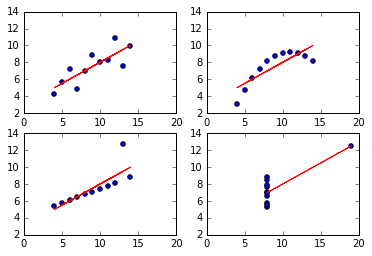

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(0, len(data_t)):
    d = data_t[i] # Get the individual dataset
    xs = d[:,0]
    ys = d[:,1]
    predict_y = lin_regs[i]["intercept"] + lin_regs[i]["slope"] * xs # Straigt line function

    plt.subplot(221+i) # 2 rows, 2 columns, current plot + i (starts at zero)
    plt.scatter(xs,ys)
    plt.plot(xs,predict_y, 'r')
    plt.xlim(xmin=0, xmax=20) # Standadize x axis min
    plt.ylim(ymin=2, ymax=14) # Standadize y axis min
    
plt.show()

### Explain - in your own words - what you think my point with this exercise is.

Other than learning how to, extract and transform data, use numpy and matlibplot, we think it is fair to say that up until the plotting the data looks very similiar. And indeed they do on the mean, variance, pearson correlation which we have calculated.

However, looking at the data plots it is easy to see how different each dataset really is. Visualization is a really important factor to help understand your data better.

## Assignment 1B: Slicing data

### We'll be combining information about PdDistrict and Category to explore differences between SF's neighborhoods. First, simply list the names of SF's 10 police districts.

We begin by loading the cvs file. Containing all the crime records, and parse it into a dictonary, for easy access.

Note that we ignore any crime that do not have a district.

In [3]:
from csv import reader

def parseCrimeCsv(row):
    return {
        'IncidntNum': line[0],
        'Category': line[1],
        'Descript': line[2],
        'DayOfWeek': line[3],
        'Date': line[4],
        'Time': line[5],
        'PdDistrict': line[6],
        'Resolution': line[7],
        'Address': line[8],
        'X': line[9],
        'Y': line[10],
        'Location': line[11],
        'PdId': line[12]
    }

with open('../SFPD_Incidents_-_from_1_January_2003.csv', 'r') as infile:    
    data = [parseCrimeCsv(line) for line in list(reader(infile))[1:] if not line[6] == '']

Now that the file have been loaded into memory we can extract all the districts.
We do this by taking value ` PdDistrict ` of all records, and insert them into a set.

In [2]:
PdDistrictSet = set([i['PdDistrict'] for i in data])
PdDistrictSet

{'BAYVIEW',
 'CENTRAL',
 'INGLESIDE',
 'MISSION',
 'NORTHERN',
 'PARK',
 'RICHMOND',
 'SOUTHERN',
 'TARAVAL',
 'TENDERLOIN'}

### Which has the most crimes? Which has the most focus crimes?

If we being finding the district with the most overall crimes.
We begin with creating a `Counter` object, were we input the districts of the dataset.
This object, helps us counting the occorences of the given values.

Lastly we call the ` most_common(1) ` on the `Counter` to extract the district with the most crimes overall.

In [3]:
from collections import Counter

DistrictCrimeCounter = Counter([d['PdDistrict'] for d in data])

DistrictCrimeCounter.most_common(1)

[('SOUTHERN', 335978)]

By looking at hthe output above, we can se that **Southern** is the district with the most crimes overall with a total count of 335978 crimes from Jan 2003 to Jan 2016.

** Which has the most focus crimes?**
To do this we first define the focus crimes, these are taken from the exercises from [week 3](http://nbviewer.jupyter.org/github/suneman/socialdataanalysis2016/blob/master/lectures/Week3.ipynb):

In [4]:
focuscrimes = set([
        'WEAPON LAWS',
        'PROSTITUTION',
        'DRIVING UNDER THE INFLUENCE',
        'ROBBERY',
        'BURGLARY',
        'ASSAULT',
        'DRUNKENNESS',
        'DRUG/NARCOTIC',
        'TRESPASS',
        'LARCENY/THEFT',
        'VANDALISM',
        'VEHICLE THEFT',
        'STOLEN PROPERTY',
        'DISORDERLY CONDUCT'
    ])

Now that we have defined the focus crimes, we can filter our dataset. So that we get a new data set that only contains the records for these crimes. We do this by utilizing the build in filter function.

Then we do the same operatios a above, to get the district with the most focus crimes.

In [5]:
data_filtered_for_focus_crimes = filter(lambda c: c['Category'] in list(focuscrimes), data)

       
most_common_focus_crime_by_dist = Counter([d['PdDistrict'] for d in data_filtered_for_focus_crimes])
most_common_focus_crime_by_dist.most_common(1)

[('SOUTHERN', 191521)]

We see that it is again the district south that have the most focus crimes, just as it also had with all crimes.
However this time around we are down to 191521 crimes commited between Jan 2003 and Jan 2016.

### Next, we want to generate a slightly more complicated graphic. I'm interested to know if there are certain crimes that happen much more in certain neighborhoods than what's typical. Below I describe how to get that plot going

#### First, we need to calculate the relative probabilities of seeing each type of crime in the dataset as a whole. That's simply a normalized version of this plot. Let's call it P(crime).

Firstly we have to create a `Counter` for the categories. Then we can use list comprehention, over the output of `most common`, to create a nicely structred dataset. 

In [6]:
from __future__ import division

# DistrictCrimeCounter

CatetoryCrimeCounter = Counter([d['Category'] for d in data])

p_crime = {}
for k,v in CatetoryCrimeCounter.most_common():
    p_crime[k] = v/len(data)

p_crime

{'ARSON': 0.0017349745013750567,
 'ASSAULT': 0.0875342429177903,
 'BAD CHECKS': 0.0004571062398205751,
 'BRIBERY': 0.0003551117400475262,
 'BURGLARY': 0.04178837476303634,
 'DISORDERLY CONDUCT': 0.004770779376818946,
 'DRIVING UNDER THE INFLUENCE': 0.002626224868501856,
 'DRUG/NARCOTIC': 0.05924919232104237,
 'DRUNKENNESS': 0.004795343497183136,
 'EMBEZZLEMENT': 0.0013745227351614022,
 'EXTORTION': 0.00032574159613382107,
 'FAMILY OFFENSES': 0.0005751208180920087,
 'FORGERY/COUNTERFEITING': 0.011604944864229834,
 'FRAUD': 0.019067631431394012,
 'GAMBLING': 0.00016340480068352336,
 'KIDNAPPING': 0.0025781646330067017,
 'LARCENY/THEFT': 0.20380476864336636,
 'LIQUOR LAWS': 0.0020521720556430727,
 'LOITERING': 0.0012511681307238406,
 'MISSING PERSON': 0.029413932128267428,
 'NON-CRIMINAL': 0.10625637465623582,
 'OTHER OFFENSES': 0.1426449149600833,
 'PORNOGRAPHY/OBSCENE MAT': 2.4564120364189783e-05,
 'PROSTITUTION': 0.00831068272234534,
 'RECOVERED VEHICLE': 0.0033887806050249647,
 'ROBBE

#### Next, we calculate that same probability distribution but for each PD district, let's call that P(crime|district).

Now we do the same, however we do it per district instead.

Our result is a dictonary, with the district as key, followed by a list, containing dictionaries again, with the crime category as key and properbility as value.

In [7]:
p_crime_district = {}
l = len(data)
for district in list(PdDistrictSet):
    counter = Counter([d['Category'] for d in data if d['PdDistrict'] == district])
    p_crime_district[district] = {}
    for k,v in counter.most_common():
            p_crime_district[district][k] = v / len(list(counter.elements()));
    
    
p_crime_district

{'BAYVIEW': {'ARSON': 0.004446580305134691,
  'ASSAULT': 0.10975448750785545,
  'BAD CHECKS': 0.0003538252736864897,
  'BRIBERY': 0.0006337169080952054,
  'BURGLARY': 0.044397150386303263,
  'DISORDERLY CONDUCT': 0.002476776915805428,
  'DRIVING UNDER THE INFLUENCE': 0.002091265796714178,
  'DRUG/NARCOTIC': 0.04878035900062844,
  'DRUNKENNESS': 0.00274610660174589,
  'EMBEZZLEMENT': 0.0012938386873610444,
  'EXTORTION': 0.00020595799513094175,
  'FAMILY OFFENSES': 0.0008343939289920205,
  'FORGERY/COUNTERFEITING': 0.008502368516944006,
  'FRAUD': 0.010113065658352653,
  'GAMBLING': 0.0002693296859404623,
  'KIDNAPPING': 0.0037072439123569515,
  'LARCENY/THEFT': 0.11580120300593054,
  'LIQUOR LAWS': 0.0013255245327658046,
  'LOITERING': 0.0005016925522420376,
  'MISSING PERSON': 0.05471089306555273,
  'NON-CRIMINAL': 0.07021055244271464,
  'OTHER OFFENSES': 0.18928595947380372,
  'PORNOGRAPHY/OBSCENE MAT': 2.640487117063356e-05,
  'PROSTITUTION': 0.0006918076246705992,
  'RECOVERED VEHI

#### Now we look at the ratio P(crime|district)/P(crime). That ratio is equal to 1 if the crime occurs at the same level within a district as in the city as a whole. If it's greater than one, it means that the crime occurs more frequently within that district. If it's smaller than one, it means that the crime is rarer within the district in question than in the city as a whole. 

#### For each district plot these ratios for the 14 focus crimes. My plot looks like this

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000006D00EF0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000043F1C908>]], dtype=object)

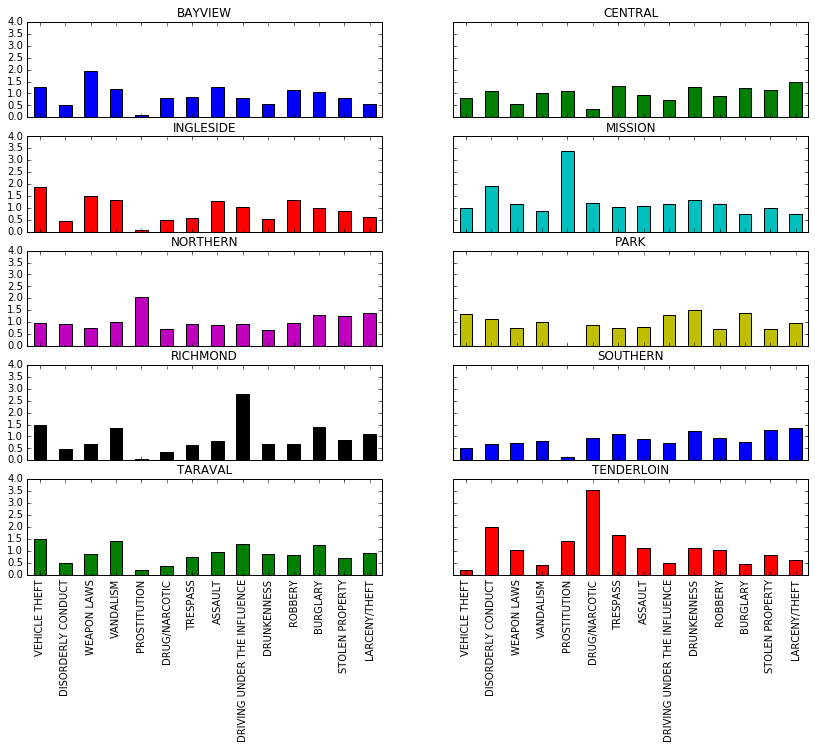

In [8]:
import pandas as pd
%matplotlib inline

def calcRatioForDistrict(districtCounter, overAllCounter, district):
    ys = []
    xs = []
    for fc in list(focuscrimes):
        ys.append(districtCounter[fc] / overAllCounter[fc])
        xs.append(fc)
    return pd.Series(ys, index=xs)
    
series = {}
for district in list(PdDistrictSet):
    series[district] = calcRatioForDistrict(p_crime_district[district], p_crime, district)

df = pd.DataFrame(series)
df.plot(kind="bar", subplots=True, figsize=(14,14),layout=(7,2), legend=False,sharey=True)

#### Comment on the top crimes in Tenderloin, Mission, and Richmond. Does this fit with the impression you get of these neighborhoods on Wikipedia?

**Tenderloin**

The top crime in Tenderloin is by far DRUG/NARCOTICS as illustrated above. Looking through articles and wikipedia, it does seem to be representative current/past activity in the area. 

From [Wikipedia](https://en.wikipedia.org/wiki/Tenderloin,_San_Francisco#Crime): *"The first block of Turk Street, between Taylor and Mason, had one of the highest rates of violence and drug activity in San Francisco, according to a survey conducted by the Tenderloin Housing Clinic."*

**Mission**

Prostitution. The top crime in Mission with some margin. Wikipedia does not give any indication about prostitution or crime in general for the district.

Doing a *leading* search on google, there does seem to be articles that mentions prostitution is on the [uptick](http://missionlocal.org/2014/06/prostitution-on-capp-street-increasing-say-residents/) recently.

**Richmond**

Richmond has the highest ratio of crimes related to DRIVING UNDER THE INFLUENCE (DUI) in San Francisco. Oddly, both DRUNKENESS and DRUG/NARCOTIC are very low in the area.

We were not able to find any information that backs these statistics.

#### Even though we only plotted the ratios for our 14 focus crimes, I asked you to calculate the ratios based on all crime categories. Why do you think I wanted to include all crime types in the calculation?

Not including the other crimes the focus crime ratios will inheritly become larger.

## Assignment 1C: KNN

### Begin by using `geoplotlib` to plot all incidents of the three crime types on their own map using [`geoplotlib.kde()`](https://github.com/andrea-cuttone/geoplotlib/blob/master/examples/kde.py). This will give you an idea of how the varioius crimes are distributed across the city.

Here we define the new focus crimes.
Then we create a dictionary that contains all the crimes from the tree specific focus crimes.
So that on the key `PROSTITUTION` the value is a list containing all of these crimes.

In [5]:
focusCrimes = ['PROSTITUTION', 'DRUG/NARCOTIC', 'DRIVING UNDER THE INFLUENCE']

filteredCrimes = {}
for f in focusCrimes:
    filteredCrimes[f] = filter(lambda c: c['Category'] == f and float(c['Y']) < 90.0, data) # We remove some crimes located at the north pole
    


Then we create a dictionary that cointains two lists, with all the latitutes and longtitues.
This is the structure that `geoplotlib` accepts.
We also construct a `Bounding Box` for San Francisco so that we have a nice view box.

In [8]:
from geoplotlib.utils import BoundingBox

def createLongAndLatList(data):
    return {'lat': [float(d['Y']) for d in data], 'lon': [float(d['X']) for d in data]}

# San Francisco
bbox_SF = BoundingBox(north=37.83, west=-122.52, south=37.67, east=-122.35)

In [1]:
import geoplotlib as glp
from geoplotlib.utils import BoundingBox, DataAccessObject

for fc in focusCrimes:
    print "Plotting " + fc
    glp.kde(createLongAndLatList(filteredCrimes[fc]), bw=5)
    glp.set_bbox(bbox_SF)
    glp.inline(width=900)

NameError: name 'focusCrimes' is not defined

#### Next, it's time to set up your model based on the actual data. You can use the code supplied in the book or try out scikit-learn's KNeighborsClassifier. If you end up using the latter (recommended), you may want to check out this example to get a sense of the usage.

In [26]:
import numpy as np
import pylab as pl
from sklearn import neighbors, datasets

allLats = []
allLons = []
Y = []

def times(n, v):
    return [v for _ in range(0,n)]

for fc in focusCrimes:
    ll = createLongAndLatList(filteredCrimes[fc])
    allLats.extend(ll['lat'])
    allLons.extend(ll['lon'])
    Y.extend(times(len(ll['lon']), focusCrimes.index(fc)))

    
X = np.array([[allLats[i],allLons[i]] for i in range(0, len(allLons))])

Y = np.array(Y)

h = .001 # step size in the mesh



knn=neighbors.KNeighborsClassifier()

# # we create an instance of Neighbours Classifier and fit the data.
knn.fit(X, Y)

# # Plot the decision boundary. For that, we will asign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x_min, x_max = X[:,0].min() - 0.02, X[:,0].max() + 0.02
y_min, y_max = X[:,1].min() - 0.02, X[:,1].max() + 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

# # Put the result into a color plot
Z = Z.reshape(xx.shape)


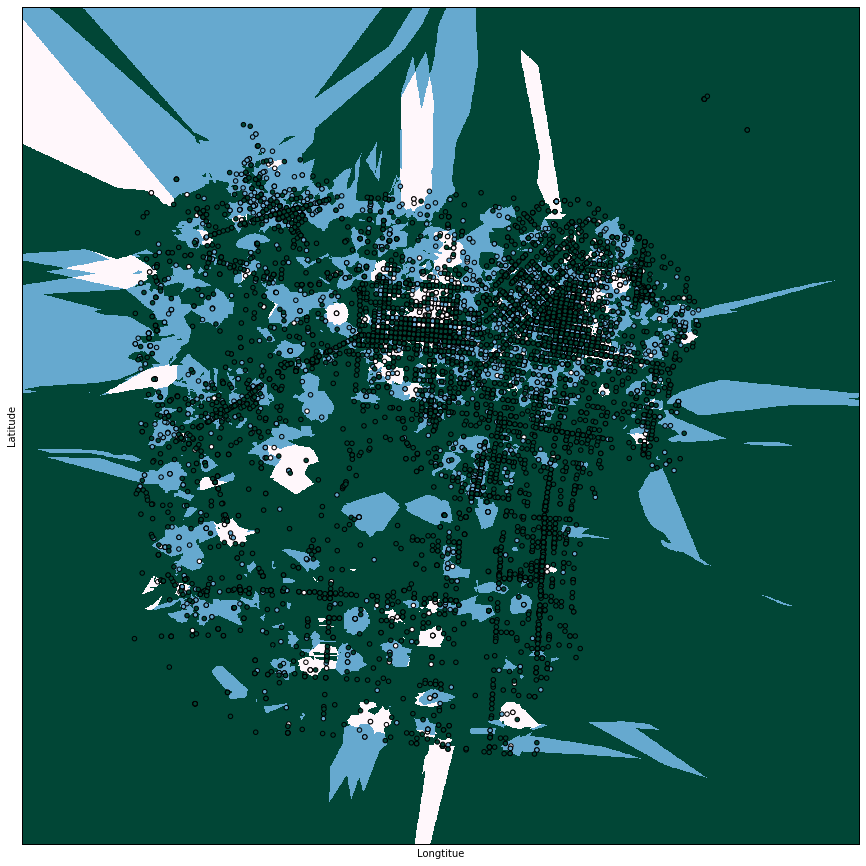

In [27]:
%matplotlib inline

pl.figure(1, figsize=(15, 15))
pl.set_cmap(pl.cm.Paired)
pl.pcolormesh(xx, yy, Z, cmap='PuBuGn')

# # Plot also the training points
pl.scatter(X[:,0], X[:,1], c=Y, cmap='PuBuGn')
pl.xlabel('Longtitue')
pl.ylabel('Latitude')

pl.xlim(xx.min(), xx.max())
pl.ylim(yy.min(), yy.max())
pl.xticks(())
pl.yticks(())


pl.show()

## Assignment 1D: Multiple regression and the Red Baron